In [1]:
import numpy as np
from pathlib import Path
from thesispy.experiments.instance import read_controlpoints, read_transform_params
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from thesispy.plot_utils import *

In [2]:
out_dir = Path('output/missed_pixels/out/')
files = [f for f in sorted((out_dir / "controlpoints.R0").iterdir(), key=lambda m: int(m.stem.split('.')[0])) if f.is_file()]
_, grid_spacing, grid_origin = read_transform_params(out_dir / 'TransformParameters.0.txt')

In [3]:
def plot_cpoints(
    points,
    grid_spacing,
    grid_origin,
    alpha=0.8,
    color='red',
    plot_init=True,
    slice=None,
    ax=None,
):
    points_slice = points
    if len(points.shape) == 4:
        if slice is None:
            slice = points.shape[2] // 2
        points_slice = points[:, :, slice, :]

    grid_spacing = np.array(grid_spacing)
    grid_origin = np.array(grid_origin)

    grid_origin = grid_origin + 0.5
    X, Y = np.meshgrid(
        *[
            np.arange(
                grid_origin[i],
                grid_origin[i] + grid_spacing[i] * points_slice.shape[i],
                grid_spacing[i],
            )
            for i in range(len(points_slice.shape[:-1]))
        ]
    )

    colormap_colors = ["red", "green", "blue", "black"]
    cmap = LinearSegmentedColormap.from_list("quadrants", colormap_colors)

    colors = np.zeros(points_slice.shape[:-1])
    levels = int(np.ceil(points_slice.shape[0] / 2))
    for level in range(levels):
        level_color = (level+1) / levels
        max_index = points_slice.shape[0]-1-level
        colors[level, level:max_index+1] = level_color
        colors[max_index, level:max_index+1] = level_color
        colors[level:max_index+1, level] = level_color
        colors[level:max_index+1, max_index] = level_color

    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.gca()

    if plot_init:
        ax.scatter(Y, X, marker="+", c=colors, cmap=cmap, alpha=0.5, s=20)

    ax.grid(False)
    ax.scatter(
        points_slice[..., 0],
        points_slice[..., 1],
        marker="s",
        s=15,
        c=colors,
        cmap=cmap,
        alpha=alpha,
    )

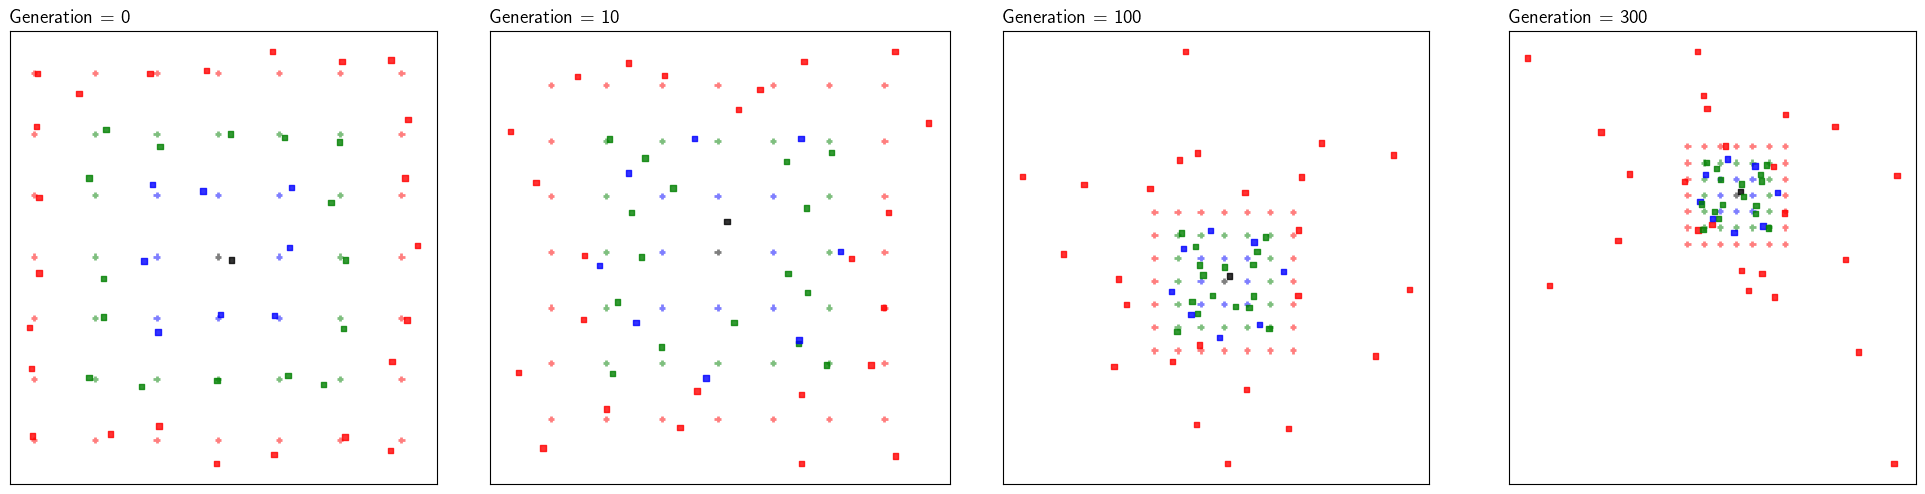

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plot_intervals = [0, 10, 100, 300]
n_intervals = len(plot_intervals)

for n, i in enumerate(plot_intervals):
    cpoints = read_controlpoints(files[i])
    plot_cpoints(cpoints, grid_spacing, grid_origin, ax=axes[n])
    axes[n].set_xticks([])
    axes[n].set_yticks([])
    axes[n].set_title(f"Generation = {i}", fontsize=14)
    axes[n].set_aspect('equal')

plt.tight_layout()
plt.savefig("missedpixels_controlpoints.pdf")

In [5]:
from thesispy.experiments.wandb_client import get_run_result

run_result_0 = get_run_result("synthetic_1_constrained_selection", "3hp1vybk")
run_result_10 = get_run_result("synthetic_1_constrained_selection", "y15mwrmb")

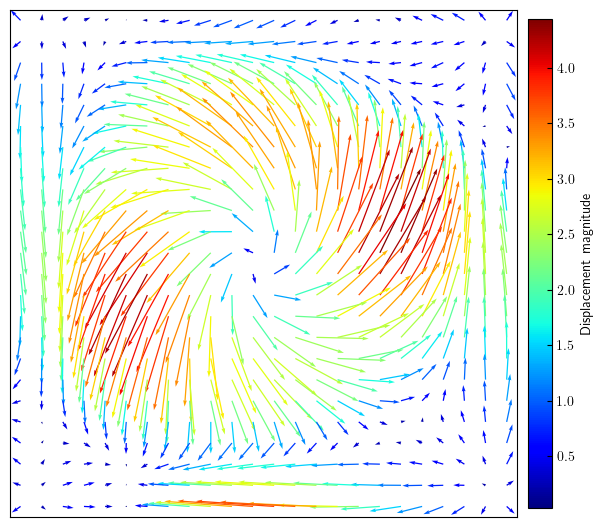

In [16]:
from thesispy.experiments.validation import plot_voxels, plot_dvf

plot_dvf(run_result_0.dvf)
plt.savefig("dvf_c0.pdf", bbox_inches='tight')

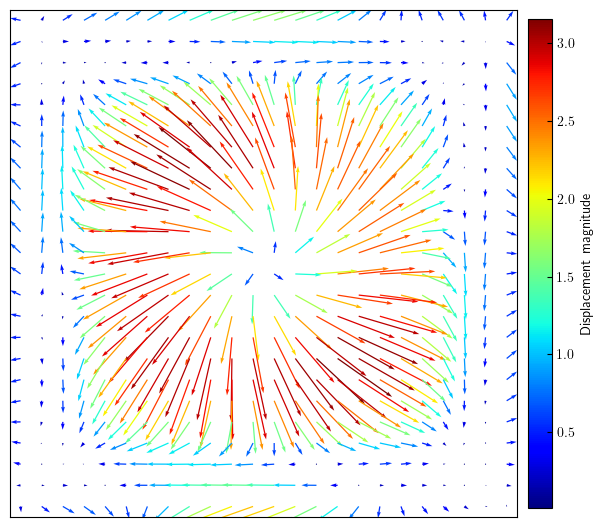

In [15]:
plot_dvf(run_result_10.dvf)
plt.savefig("dvf_c10.pdf", bbox_inches='tight')

In [27]:
transform_params = np.loadtxt(out_dir / "R0_transform_params_constraints.dat")
constraint_values = transform_params[:, 0]
transform_params = transform_params[:, 1:]

In [29]:
import shutil

template_transform_file = out_dir / "transform_params_template.txt"
out_dir_transform_files = out_dir / "transform_param_files"

for generation, transform_param in enumerate(transform_params):
    shutil.copy(template_transform_file, out_dir_transform_files / f"{generation}.txt")
    with open(out_dir_transform_files / f"{generation}.txt", "a") as f:
        f.write("(TransformParameters ")
        for param in transform_param:
            f.write(f"{param} ")
        f.write(")")


In [25]:
def plot_dvf(data, title, scale=1, invert=False, slice=None, ax=None):
    if len(data.shape[:-1]) > 2:
        if slice is None:
            slice = data.shape[2] // 2
        data = data[:, :, slice, :]

    X, Y = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]))
    if invert:
        X = X + data[..., 1]
        Y = Y + data[..., 0]
        data = -data

    X = X + 0.5
    Y = Y + 0.5

    u = data[:, :, 0]
    v = data[:, :, 1]
    c = np.sqrt(u**2 + v**2)

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    else:
        fig = ax.get_figure()

    qq = ax.quiver(
        X, Y, v, u, c, scale=scale, units="xy", angles="xy", scale_units="xy", cmap=plt.cm.jet
    )

    ax.set_title(title)
    ax.set_xlim(0, data.shape[0])
    ax.set_ylim(0, data.shape[1])
    ax.set_aspect("equal")
    ax.invert_yaxis()
    ax.invert_xaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    # fig.colorbar(qq, fraction=0.045, pad=0.02, label="Displacement magnitude", ax=ax)

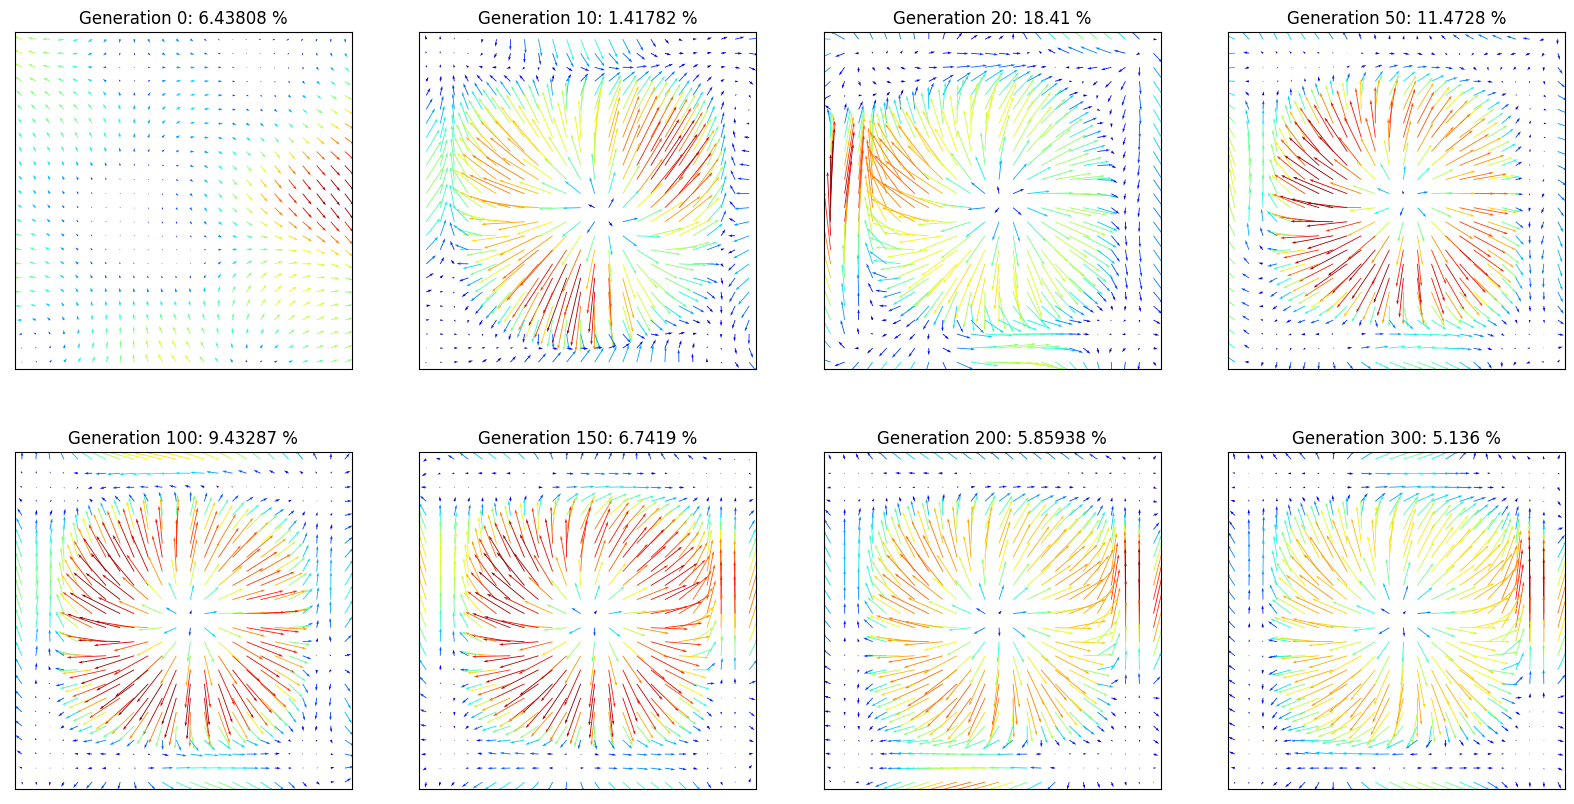

In [76]:
from thesispy.elastix_wrapper.wrapper import get_run_result
from thesispy.definitions import Collection


# subplot of dvf for generations 0, 50, 200, 310

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

set1 = [i for i in range(8)]
set2 = [i*5 for i in range(8)]
set3 = [i*10 for i in range(8)]
set4 = [0, 10, 20, 50, 100, 150, 200, 300]

for i, n in enumerate(set4):
    run_result = get_run_result(Collection.SYNTHETIC, 1, out_dir_transform_files / f"{n}.txt")
    dvf = run_result.dvf
    plot_dvf(dvf, f"Generation {n}: {constraint_values[n]} %", scale=1, ax=axes[i // 4, i % 4])